In [4]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize 

import calendar
import datetime
import pytz
import re
import string
from collections import Counter

from tweet_grabber import tweet_grabber

In [5]:
# tweet_grabber('KimKardashian', 0, 'kkw_test.csv')

Previously on Keeping up with the Kardashians:

Since the Twitter API only allows for the scraping of the last ~3500 or so tweets, we used Python's "Get Old Tweets" module to write a tweet_grabber function to download all of Kim's tweets and save them to a csv-file.

This gold mine gives us access to ALL of Kim's tweets since the inception of her Twitter account on March 21st, 2009 when she tweeted:

"Hey guys it's Kim Kardashian! I finally signed up for Twitter! There are a few fakes so just know this is the real me!!!"

A true legend. 

Let's take a closer look at her twitter activities over the course of her career.

In [7]:
pd.set_option('display.max_colwidth', 200)

df = pd.read_csv("kkw_test.csv")
df = df.replace('NaN', np.nan)

times = pd.to_datetime(df['date'], utc=True) 
df['date'] = pd.Index(times).tz_convert('US/Pacific')

'''
After replacing NaN with np.nan, we're converting the values in our "date" column 
to timezone-aware datetime objects (Tweet timestamps are set to UTC by default) 
and convert them to Calabasas time aka US/Pacific time, since that is Kim's timezone.

(type(df['date']) will return "dtype: datetime64[ns, US/Pacific])
'''

df.head(3)

,username,date,retweets,favorites,text,geo,mentions,to,hashtags,id,permalink
0,KimKardashian,2019-08-07 07:36:40-07:00,141,6339,Thank you Isabel! She’s the best spray tanner btw! @kkwbeautypic.twitter.com/9BLp6ZsDsp,NaN,@kkwbeautypic,NaN,NaN,1159111119228657664,https://twitter.com/KimKardashian/status/1159111119228657664
1,KimKardashian,2019-08-06 07:11:44-07:00,858,15187,Matte Smoke! White eyeliner is one of my favorite looks with a 90’s inspo black smoke eye! All of the lip liners for this collection are a few shades darker than the matte lipstick. I’m wearing li...,NaN,NaN,NaN,NaN,1158742455375683586,https://twitter.com/KimKardashian/status/1158742455375683586
2,KimKardashian,2019-08-05 13:20:18-07:00,137,3097,I used to wear this burgundy lip all the time in high school! These are the new matte lipsticks and liners for the matte cocoa collectionpic.twitter.com/58rVwHJnlr,NaN,NaN,NaN,NaN,1158472819656679425,https://twitter.com/KimKardashian/status/1158472819656679425


Since we might want to do some sentiment analysis and/or wordclouds later on, we begin by cleaning Kim's data. Let's first create a "clean" copy of our dataframe. 

For comparison purposes, we will only keep the text column and keep on adding new columns 
with every step of our cleaning process. That way, we will better be able to see 
what is actually happening. 

In [8]:
clean = df.copy().drop(columns = ['username', 'retweets', 'favorites', 'geo', 'mentions', 
                                  'hashtags', 'id', 'permalink'])


def tweet_cleaner(data):
    
    # adding empty 'cleaned' column to df to which cleaned tweets will be written
    data["cleaned"] = ""
    
    for index, row in data.iterrows():
        tweet = str(row['text'])
        
        # removing RTs - we only want pure Kim content to catch a glimpse into her soul 
        # this is important mostly for older tweets before the introduction of the
        # "retweet and comment" feature in 2015 when retweets were done manually
        tweet = re.sub("\s*RT\s*@[^:]*:*","",tweet)
        
        # removing @mentions and #-characters (keeping the word/tag itself tho)
        tweet = re.sub("@[A-Za-z0-9]+","",tweet) 
        tweet = re.sub("#","",tweet)  
        
        # removing some typical urls
        tweet = re.sub("(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*","",tweet)
        tweet = re.sub("pic\.twitter\.com\S*\s?","",tweet)
        tweet = re.sub("bit\.ly.*\s?","",tweet)
        tweet = re.sub("instagr\.am.*\s?","",tweet)
        tweet = re.sub("t\.co.*\s?","",tweet) 
        tweet = re.sub("twitter\.com.*\s?","",tweet)
        tweet = re.sub("[\w/\-?=%.]+\.[\(com)/\-?=%.]+", "", tweet) # removes .com urls without http or www
        
        # removing all numbers and also times (i.e. "12 PM PST"), 
        # since Kimberly likes to announce product drops and also when KUWTK is on
        tweet = re.sub(r"[0-9]+\s*([AaPp][Mm])?\s*([Pp][Ss][Tt])?\s*", "", tweet)
        tweet = re.sub("\…", "", tweet)
        
        # substituting ’ with a regular ' since it is not properly detected otherwise
        tweet = re.sub("’","'",tweet)
        
        # miss me with that punctuation Kim
        tweet  = "".join([char for char in tweet if char not in string.punctuation]) 
        
        # placing cleaned tweet into 'cleaned' column which we created earlier
        data.at[index, 'cleaned'] = tweet


tweet_cleaner(clean)

# removing all rows where only an empty string or a single space remained
clean = clean[(clean['cleaned'] != " ") & (clean['cleaned'] != "")]

On to tokenizing and lemmatizing.

Tokenization basically turns each tweet into a list with each word being an individual item (=token). 
During tokenization, we're also pos tagging each tweet on order to have better results with 
lemmatization. (Lemmatization removes inflection, it basically returns the "dictionary form" of a word.)

Since the WordNetLemmatizer (which we'll use to lemmatize Kim's tweets) works more accurately if we also tell it the part of speech tag of a word (verb, adverb, noun, etc.), we're going to feed that to her also. 
First tho, we need to convert the pos tags nltk.pos_tag() uses (treebank tags, since it was trained on the Treebank corpus) to the kinds of tags the WordNetLemmatizer understands.

In [12]:
# This is the function we'll use for converting the pos tags:

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'  # returning 'n' here because it's the default tag which we'll fall back on in that case


# our actual lemmatization function, 
# which 1.) tokenizes, 2. pos-tags, and 3.) lemmatizes a tweet:

def tokenize_lemmatize(tweet):
    
    wn = nltk.WordNetLemmatizer()
    
    lemmatized_tweet = []
    
    tokens = nltk.word_tokenize(tweet) # list with individual words as items
    tagged = nltk.pos_tag(tokens) # returns a list of (word, tag)-tuples
    
    for item in tagged:
        word = item[0]
        tag = item[1]
        lemmatized = wn.lemmatize(word, pos=get_wordnet_pos(tag))
        lemmatized_tweet.append(lemmatized)
        
    return lemmatized_tweet


# We're also filtering out stop words like literal trash, ugh #relatable
def remove_stopwords(tweet):
    stop_words = stopwords.words('english')
    more_noise = ['i’m', "im", "w", "u"]
    stop_words.extend(more_noise)

    # first condition removes stopwords, second condition removes empty strings 
    tweet = [word for word in tweet if word.lower() not in stop_words and word]
    return tweet


lemmatized = [tokenize_lemmatize(tweet) for tweet in clean['cleaned']]
stopwords_removed = [remove_stopwords(tweet) for tweet in lemmatized]
clean['lemmatized'] = stopwords_removed

In [13]:
clean.head(3)

,date,text,to,cleaned,lemmatized
0,2019-08-07 07:36:40-07:00,Thank you Isabel! She’s the best spray tanner btw! @kkwbeautypic.twitter.com/9BLp6ZsDsp,NaN,Thank you Isabel Shes the best spray tanner btw,"[Thank, Isabel, Shes, best, spray, tanner, btw]"
1,2019-08-06 07:11:44-07:00,Matte Smoke! White eyeliner is one of my favorite looks with a 90’s inspo black smoke eye! All of the lip liners for this collection are a few shades darker than the matte lipstick. I’m wearing li...,NaN,Matte Smoke White eyeliner is one of my favorite looks with a s inspo black smoke eye All of the lip liners for this collection are a few shades darker than the matte lipstick Im wearing lipliner ...,"[Matte, Smoke, White, eyeliner, one, favorite, look, inspo, black, smoke, eye, lip, liner, collection, shade, darker, matte, lipstick, wear, lipliner, lipstick, Runway, dropping]"
2,2019-08-05 13:20:18-07:00,I used to wear this burgundy lip all the time in high school! These are the new matte lipsticks and liners for the matte cocoa collectionpic.twitter.com/58rVwHJnlr,NaN,I used to wear this burgundy lip all the time in high school These are the new matte lipsticks and liners for the matte cocoa collection,"[use, wear, burgundy, lip, time, high, school, new, matte, lipstick, liner, matte, cocoa, collection]"


In [14]:
# Stemming is different to Lemmatization in the approach it uses to produce root forms of words and the word produced. 
# Stems are created by removing the suffixes or prefixes used with a word.
# let's look at some different stemmers to see, whether we need stemming and if yes, which stemmer we should use.

stem = pd.DataFrame(clean['lemmatized'])

# I chose to go with three of the most popular stemmers within nltk:
# PorterStemmer, LancasterStemmer and SnowballStemmer, with the first one supposedly being 
# less aggressive than the latter two in their... chopping intensity

def ps_stemming(tweet):
    ps = nltk.PorterStemmer()
    tweet = [ps.stem(word) for word in tweet]
    return tweet


stemmed = [ps_stemming(tweet) for tweet in stem['lemmatized']]
stem["PorterStemmer"] = stemmed


def ls_stemming(tweet):
    ls = nltk.LancasterStemmer()
    tweet = [ls.stem(word) for word in tweet]
    return tweet
 

stemmed = [ls_stemming(tweet) for tweet in stem['lemmatized']]
stem["LancasterStemmer"] = stemmed


def ss_stemming(tweet):
    ss = nltk.SnowballStemmer('english')
    tweet = [ss.stem(word) for word in tweet]
    return tweet
 

stemmed = [ls_stemming(tweet) for tweet in stem['lemmatized']]
stem["SnowballStemmer"] = stemmed

# Let's look at the first 10 results to see what we're dealing with
stem.head(10)

,lemmatized,PorterStemmer,LancasterStemmer,SnowballStemmer
0,"[Thank, Isabel, Shes, best, spray, tanner, btw]","[thank, isabel, she, best, spray, tanner, btw]","[thank, isabel, she, best, spray, tan, btw]","[thank, isabel, she, best, spray, tan, btw]"
1,"[Matte, Smoke, White, eyeliner, one, favorite, look, inspo, black, smoke, eye, lip, liner, collection, shade, darker, matte, lipstick, wear, lipliner, lipstick, Runway, dropping]","[matt, smoke, white, eyelin, one, favorit, look, inspo, black, smoke, eye, lip, liner, collect, shade, darker, matt, lipstick, wear, liplin, lipstick, runway, drop]","[mat, smok, whit, eyelin, on, favorit, look, inspo, black, smok, ey, lip, lin, collect, shad, dark, mat, lipstick, wear, liplin, lipstick, runway, drop]","[mat, smok, whit, eyelin, on, favorit, look, inspo, black, smok, ey, lip, lin, collect, shad, dark, mat, lipstick, wear, liplin, lipstick, runway, drop]"
2,"[use, wear, burgundy, lip, time, high, school, new, matte, lipstick, liner, matte, cocoa, collection]","[use, wear, burgundi, lip, time, high, school, new, matt, lipstick, liner, matt, cocoa, collect]","[us, wear, burgundy, lip, tim, high, school, new, mat, lipstick, lin, mat, coco, collect]","[us, wear, burgundy, lip, tim, high, school, new, mat, lipstick, lin, mat, coco, collect]"
3,"[Matte, Cocoa]","[matt, cocoa]","[mat, coco]","[mat, coco]"
4,"[new, matte, formula, lipstick, soooooo, good]","[new, matt, formula, lipstick, soooooo, good]","[new, mat, formul, lipstick, soooooo, good]","[new, mat, formul, lipstick, soooooo, good]"
5,"[Matte, Smoke]","[matt, smoke]","[mat, smok]","[mat, smok]"
6,"[cant, wait, guy, try, Launching, Friday, kkwbeauty]","[cant, wait, guy, tri, launch, friday, kkwbeauti]","[cant, wait, guy, try, launch, friday, kkwbeauty]","[cant, wait, guy, try, launch, friday, kkwbeauty]"
7,"[collection, feature, Pan, Eyeshadow, Palettes, Lipsticks, brand, new, matte, formula, Lip, Liners, Eyeliners, Matte, Smoke, Matte, Cocoa, two, entirely, different, color, range, many, look, creat...","[collect, featur, pan, eyeshadow, palett, lipstick, brand, new, matt, formula, lip, liner, eyelin, matt, smoke, matt, cocoa, two, entir, differ, color, rang, mani, look, creat, collect]","[collect, feat, pan, eyeshadow, palet, lipstick, brand, new, mat, formul, lip, lin, eyelin, mat, smok, mat, coco, two, entir, diff, col, rang, many, look, cre, collect]","[collect, feat, pan, eyeshadow, palet, lipstick, brand, new, mat, formul, lip, lin, eyelin, mat, smok, mat, coco, two, entir, diff, col, rang, many, look, cre, collect]"
8,"[excite, announce, new, inspire, collection, matte, formulas, Matte, Smoke, Matte, Cocoa, Collections, get, lot, makeup, inspiration, love, nostalgic, entire, collection]","[excit, announc, new, inspir, collect, matt, formula, matt, smoke, matt, cocoa, collect, get, lot, makeup, inspir, love, nostalg, entir, collect]","[excit, annount, new, inspir, collect, mat, formula, mat, smok, mat, coco, collect, get, lot, makeup, inspir, lov, nostalg, entir, collect]","[excit, annount, new, inspir, collect, mat, formula, mat, smok, mat, coco, collect, get, lot, makeup, inspir, lov, nostalg, entir, collect]"
9,[guess],[guess],[guess],[guess]


At first glance it looks like PorterStemmer really is less aggressive: while LS and SS turned love into lov, 
fire into fir, brother to broth and powder to powd, the PS was not quite as harsh. 
Still tho, I feel like we might not need to use stemming for Kim's tweets, since we want to look at the actual words she uses.
Let's go back to our clean dataframe and look at our data.

In [15]:
# let's compare our cleaned data with the original data in terms of numbers 
# by plotting the yearly tweet amount bars side by side

# function for chopping the dataframe up into years
def yearly_dfs(start, end, frame, string="k"):
    """
    chops dataframe into smaller dataframes based on the year of the tweets.
    :param start: = first year (will be included)
    :param end: = last year (will be included)
    :param frame: = dataframe to be chopped up    
    
    returns:
    years - list of years (int) with start being the first item and end the last
    frames - list of dataframes with each frame containing the tweets for one calendar year
    """
    years = np.arange(start, end+1, 1)
    frames = []
    for year in years:
        # resetting index so that the individual frames will be easier to work with later
        # old index will be added as a column, so we will still be able to see the og index
        dataframe = frame[frame['date'].dt.year == year].reset_index() 
        frames.append(dataframe)
        
    return years, frames


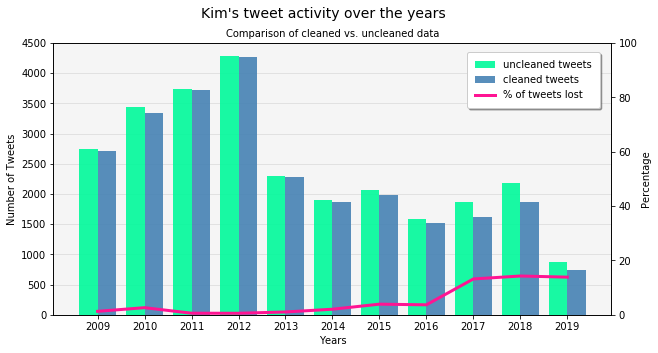

In [18]:
# this is our uncleaned data, the original k
# individual dataframes for each year based on the original dataframe

years, frames = yearly_dfs(start=2009, end=2019, frame=df)

k2009 = frames[0]
k2010 = frames[1]
k2011 = frames[2]
k2012 = frames[3]
k2013 = frames[4]
k2014 = frames[5]
k2015 = frames[6]
k2016 = frames[7]
k2017 = frames[8]
k2018 = frames[9]
k2019 = frames[10]

yearly_tweets = np.array([len(k2009), len(k2010), len(k2011), len(k2012), len(k2013), 
           len(k2014), len(k2015), len(k2016), len(k2017), len(k2018), len(k2019)])


# this is our cleaned data
_, clean_frames = yearly_dfs(2009, 2019, frame=clean, string="clean")

clean2009 = clean_frames[0]
clean2010 = clean_frames[1]
clean2011 = clean_frames[2]
clean2012 = clean_frames[3]
clean2013 = clean_frames[4]
clean2014 = clean_frames[5]
clean2015 = clean_frames[6]
clean2016 = clean_frames[7]
clean2017 = clean_frames[8]
clean2018 = clean_frames[9]
clean2019 = clean_frames[10]

cleaned_yearly_tweets = np.array([len(clean2009), len(clean2010), len(clean2011), len(clean2012), len(clean2013), 
           len(clean2014), len(clean2015), len(clean2016), len(clean2017), len(clean2018), len(clean2019)])



# let's plot!
title = "Kim's tweet activity over the years"
n_groups = len(years)
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.9

fig = plt.figure(figsize=(10,5))
fig.suptitle(title, size=14)
ax1 = fig.add_subplot(111)

unclean_bars = ax1.bar(np.array(index), yearly_tweets, 
                 bar_width, alpha=opacity, color='mediumspringgreen', label='uncleaned tweets', zorder=2)

clean_bars = ax1.bar(np.array(index + bar_width), cleaned_yearly_tweets, 
               bar_width, alpha=opacity, color='steelblue', label='cleaned tweets', zorder=2)

ax1.set_xlabel('Years')
ax1.set_ylabel('Number of Tweets')
ax1.set_title("Comparison of cleaned vs. uncleaned data", size=10)
ax1.set_facecolor('whitesmoke')
ax1.grid(axis='y', color='gainsboro', zorder=1)


ax2 = ax1.twinx()
ax2.set_ylim((0,100))
ax2.set_ylabel('Percentage')
percent_lost = np.array([100*(1-(cleaned_yearly_tweets / yearly_tweets))]).reshape((11, 1))
scatter = ax2.plot(index+0.5*bar_width, percent_lost, c='deeppink', label="% of tweets lost", linewidth=3)
plt.xticks(index + 0.5*bar_width, years, rotation=0)
fig.legend(loc='upper right', bbox_to_anchor=(0.84, 0.85), borderpad=.8, shadow=True)

plt.show()

As we can see, the changes are not too dramatic. But some tweets had to be given up:
We can safely assume that those are either url-only tweets or pre-2015 retweets with no commentary added by Kimberly herself since those are the two that we removed as ruthlessly as Jordyn Woods was removed from Kylie's house after
the Tristan Thompson "incident" in spring of 2019.
We can see that the percentage of removed tweets is increasing drastically in 2017 while her overall tweet numbers have been somewhat stagnant ever since that huge drop in 2013.
This seems to suggest that over the years, Kim has changed the way she uses twitter. Especially in the beginning, she really interacted with her fans, replying to and retweeting non-famous randoms and actively engaging with them, answering questions. This was a obviously a time before Kim Kardashian was a household name and she was still in the phase of growing her audience, the pre-Kanye era which is fundamentally different from the Kanye era. In June 2017 she launched her own beauty line, KKW Beauty and in November 2017 she launched her own fragrance line, KKW Fragrance. Both of these lines she heavily promotes on twitter, often times posting only urls or pics, which have been eliminated during our cleaning process. 
This needs to be further explored tho.

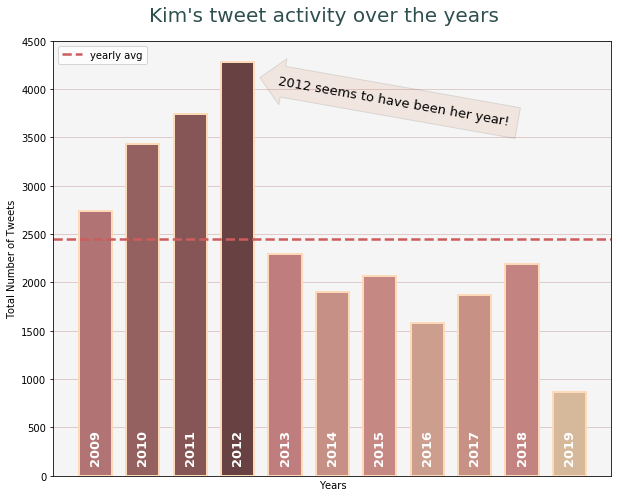

In [19]:
'''
For graphs looking only at numbers it's obviously better to use the original data
since we don't want those tweets to be discarded. They were tweets after all.

Let's make a prettier graph with colors that look like KKW lipsticks lol
'''

# Colorizing the bars based on tweet amount:
scores = np.array(yearly_tweets) # setting scale with which to measure the progression steps on the cmap
data_normalizer = matplotlib.colors.Normalize() # normalizing the data into [0.0, 1.0] interval
colormap = matplotlib.cm.get_cmap('pink_r', 512) # getting a colormap from mlp
newcmp = ListedColormap(colormap(np.linspace(0.45, 0.9, 256))) # reducing the range by slicing the cmap
colors = newcmp(data_normalizer(scores))

fig = plt.figure(figsize=(10,8))
fig.suptitle(title, fontsize=20, color='darkslategrey', y=0.94)

ax = fig.add_subplot(111)
ax.bar(years, yearly_tweets, color=colors, width=.7, zorder=2, ec='peachpuff', linewidth=2, linestyle="-")
ax.set_xlabel("Years")
ax.set_ylabel("Total Number of Tweets")
ax.set_facecolor("whitesmoke")
plt.grid(axis="y", color="rosybrown", alpha=.4, zorder=1, linewidth=1)

# adding a horizontal line for yearly average
mean = np.mean(yearly_tweets)
ax.axhline(mean, c="indianred", label="yearly avg", 
            linewidth=2.5, linestyle="dashed")
ax.legend(loc="upper left")

# annotate
annotaish = "2012 seems to have been her year!"
bbox_props=dict(boxstyle="larrow", pad=0.7, fc="chocolate", alpha=0.1, lw=1)
arrow_props=dict(facecolor='palevioletred', ec='rosybrown', shrink=0.05)
ax.annotate(annotaish, xy=(0.4,0.9), xycoords='axes fraction', rotation=-10,
             size=13, bbox=bbox_props)

# adding the years as text on each bar instead of using x-ticks
ax.set_xticks([])
bars = ax.patches
for index, bar in enumerate(bars):
    (y_bottom, y_top) = ax.get_ylim()
    xloc = years[index]
    yloc = y_bottom + 380
    ax.text(xloc, yloc, str(xloc), color="w", size=13, fontweight="demibold", rotation=90, ha="center")

    
plt.show()

/Users/karolin/PycharmProjects/my_project/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


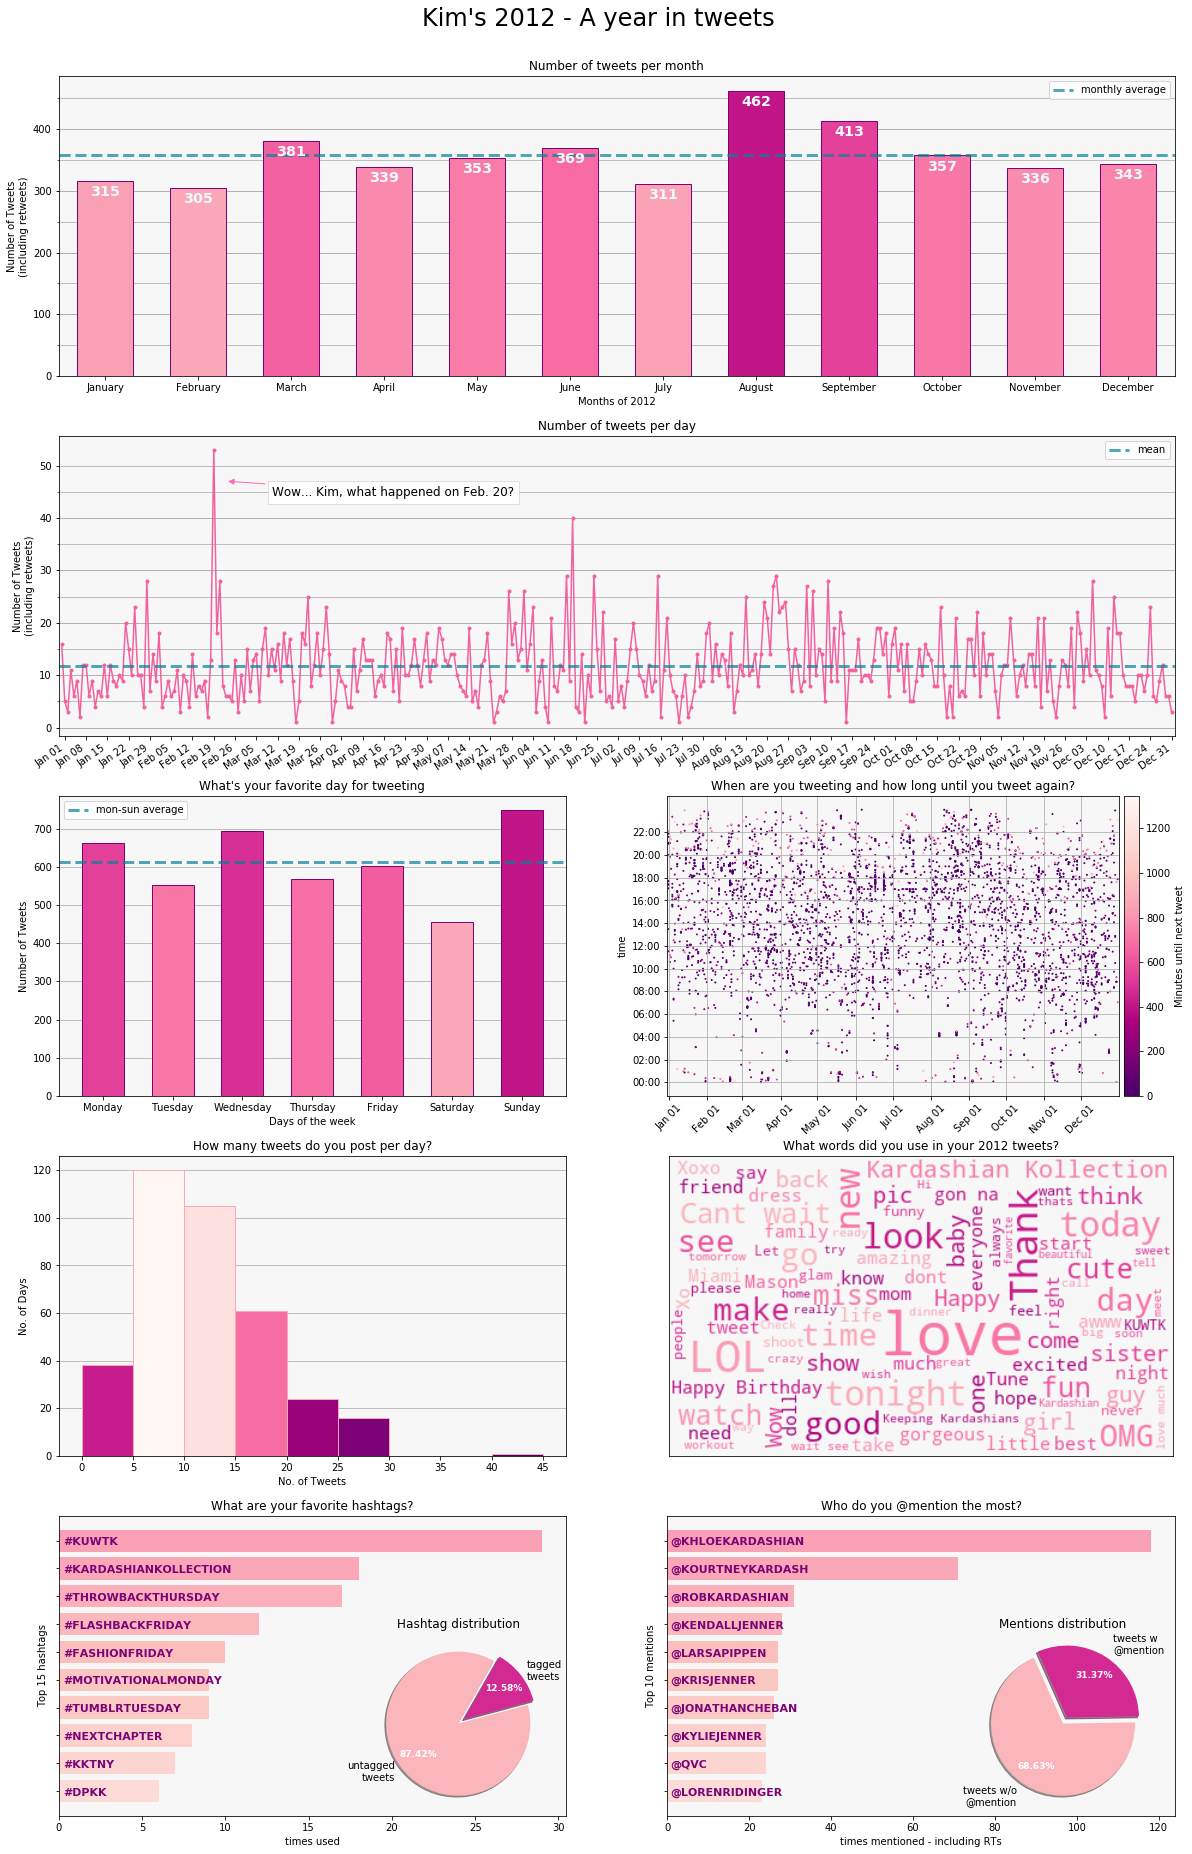

In [20]:
# let's create a bunch of cute looking charts 
# to get a grasp of what 2012 was like for Kimberly on twitter


# this is a function for labeling bars with their y values
def autolabel(rects, ax):
    # rects = ax.patches
    # get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = (height / y_height)

        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column.
        if p_height > 0.95: # arbitrary; 95% looked good to me.
            label_position = height - (y_height * 0.06)
            
        else:
            label_position = height - (y_height * 0.06)
            # label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%d' % int(height), color="#edf8fb", fontweight="semibold",
                size="x-large", ha='center', va='bottom')


# function for labeling horizontal bars
def hbar_labeler(ax, bars, label_list, x_offset=0.3):
    for index, bar in enumerate(bars):
        ax.text(bar.get_x()+x_offset, bar.get_y()+0.16, label_list[index], 
                 color="#7A0475", size=11, weight="semibold", stretch="condensed", 
                 ha='left', va='bottom')


# function to pass into plt.pie(autopct=) to label wedges with value+pct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} days\n ({p:.2f}%)'.format(p=pct,v=val)
    return my_autopct


title = "Kim's 2012 - A year in tweets"
bg_color = "#f7f7f7"
linecolor = "#078298"
fig = plt.figure(figsize=(20,32))
fig.suptitle(title, size=24, y=0.91)

# adding our axes
ax1 = plt.subplot2grid((5, 2), (0, 0), colspan=2) # monthwise tweet distribution bars
ax2 = plt.subplot2grid((5, 2), (1, 0), colspan=2) # daywise tweet distribution bars
ax3 = plt.subplot2grid((5, 2), (2, 0))            # histogram of daily tweet numbers
ax4 = plt.subplot2grid((5, 2), (2, 1))            # daily tweet hours scatter plot
ax5 = plt.subplot2grid((5, 2), (3, 0))
ax6 = plt.subplot2grid((5, 2), (3, 1))            # weekday distribution bar #6
ax7 = plt.subplot2grid((5, 2), (4, 0))            # hashtags hbars #7
ax7a = fig.add_axes([0.34, 0.115, 0.125, 0.10])   # tiny pie showing pct of hashed vs. unhashed tweets #7a
ax8 = plt.subplot2grid((5, 2), (4, 1))            # mentions hbars 8
ax8a = fig.add_axes([0.76, 0.115, 0.125, 0.10])   # tiny pie showing pct of mention vs. non-mention tweets #8a

for ax in fig.axes:
    ax.set_facecolor(bg_color)
    
ax1.set_title("Number of tweets per month")
ax2.set_title("Number of tweets per day")
ax3.set_title("What's your favorite day for tweeting")
ax4.set_title("When are you tweeting and how long until you tweet again?")
ax5.set_title("How many tweets do you post per day?")
ax6.set_title("What words did you use in your 2012 tweets?")
ax7.set_title("What are your favorite hashtags?")
ax7a.set_title("Hashtag distribution")
ax8.set_title("Who do you @mention the most?")
ax8a.set_title("Mentions distribution")


'''
ax1: bar chart showing Kim's monthly tweet distribution
'''
# data
m = Counter(k2012['date'].sort_values().dt.month)
months = [item for item in m]
month_nums = list(m.values())
monthlabels=list(calendar.month_name)[1:]

# color settings - Colorizing the x bars based on y values:
scores = np.array(month_nums) # setting scale with which to measure the progression steps on the cmap
data_normalizer = matplotlib.colors.Normalize() # normalizing the data into [0.0, 1.0] interval
colormap = matplotlib.cm.get_cmap('RdPu', 512) # getting a colormap from mlp
newcmp = ListedColormap(colormap(np.linspace(0.35, 0.7, 256))) # reducing the range by slicing the cmap
colors = newcmp(data_normalizer(scores))

# graph
ax1.bar(monthlabels, month_nums, width=0.6, zorder=2, color=colors, ec='#7a0177')
ax1.set_xlim((-0.5, 11.5))
ax1.set_xticklabels(monthlabels)
mean = np.mean(month_nums)
ax1.axhline(y=mean, label="monthly average", color=linecolor, linestyle="dashed", linewidth=3, alpha=.7)
ax1.set_yticks(np.arange(0,500,50), minor=True)
ax1.grid(axis='y', zorder=1, which='both')
ax1.legend()
ax1.set_xlabel("Months of 2012")
ax1.set_ylabel("Number of Tweets\n(including retweets)")
rects = ax1.patches 
autolabel(rects, ax1)


'''
ax2 daily tweet distribution
'''
# ax2 data
d = Counter(k2012['date'].sort_values().dt.strftime('%B %d'))
days = [item for item in d]
day_nums = list(d.values()) #[d[item] for item in d]

# ax2 graph
ax2.set_facecolor(bg_color)
ax2.plot(days, day_nums, color='#F3619F', zorder=2, marker=".")
ax2.axhline(y=np.mean(day_nums), label="mean", color=linecolor, linestyle="dashed", linewidth=3, alpha=.7)
ax2.set_xlim((-1, 366))
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.set_xticks(np.arange(1,366,7))
# setting rotation and alignment of the labels:
for label in ax2.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(35)
ax2.set_yticks(np.arange(0,50,5), minor=True)
ax2.grid(axis='y', zorder=1, which='both')
ax2.legend()
ax2.set_ylabel("Number of Tweets\n(including retweets)")

# ax2 annotation
ax2comment = "Wow... Kim, what happened on Feb. 20?"
bbox_props=dict(boxstyle="square", pad=0.4, fc="w", alpha=.9, ec="gainsboro", lw=1)
arrow_props=dict(arrowstyle="-|>", facecolor='hotpink', ec='hotpink')
ax2.annotate(ax2comment, xy=(0.15,0.85), xytext=(0.3,0.8), xycoords='axes fraction', 
             size=12, color="k", ha="center", arrowprops=arrow_props, bbox=bbox_props)



'''
ax3 weekday tweet distribution
'''
# data
weekdays = list(calendar.day_name)
weekday_tweets_2012 = [] # list with the len of each frame representing the total number of tweets for each weekday
for index in range(len(weekdays)):
    # .dt.weekday returns weekday (0=Monday...) 
    # thus creating a frame for each weekday. we're only storing the length aka total number of tweets
    dayframe = k2012[k2012['date'].dt.weekday == index].reset_index()
    weekday_tweets_2012.append(len(dayframe))


# color settings - Colorizing the x bars based on y values:
ax3_scores = np.array(weekday_tweets_2012) # setting scale with which to measure the progression steps on the cmap
data_normalizer = matplotlib.colors.Normalize() # normalizing the data into [0.0, 1.0] interval
colormap = matplotlib.cm.get_cmap('RdPu', 512) # getting a colormap from mlp
newcmp = ListedColormap(colormap(np.linspace(0.35, 0.7, 256))) # reducing the range by slicing the cmap
ax3colors = newcmp(data_normalizer(ax3_scores))

# chart
ax3.bar(weekdays, weekday_tweets_2012, width=0.6, zorder=2, color=ax3colors, ec='#7a0177')
# ax5.set_xlim((-0.5, 11.5))
ax3.set_xticklabels(weekdays)
mean = np.mean(weekday_tweets_2012)
ax3.axhline(y=mean, label="mon-sun average", color=linecolor, linestyle="dashed", linewidth=3, alpha=.7)
# ax5.set_yticks(np.arange(0,500,50), minor=True)
ax3.grid(axis='y', zorder=1, which='both')
ax3.legend()
ax3.set_xlabel("Days of the week")
ax3.set_ylabel("Number of Tweets")


'''
ax4 scatterplot of times of the day she tweeted over the year
'''
# data for scatter
x_days = k2012['date'].sort_values().dt.date
alltimes = k2012['date'].sort_values().dt.strftime('%H:%M')
y_times = [datetime.datetime.strptime(t, '%H:%M').time() for t in alltimes]
# data for colorbar gradient - figuring out timedelta between tweet and next tweet
timeit = k2012['date'].sort_values().tolist()
minutes = []
for index, time in enumerate(timeit):
    next_index = (index + 1) % len(k2012)
    # when last date in 2012 is reached, first date of 2013 is used to create the delta
    if next_index == 0:
        delta = k2013["date"].sort_values().tolist()[0] - time
    # looking at next time and creating a delta (= how long until the next tweet)
    else:  
        delta = timeit[next_index] - time     
    m = delta.seconds / 60
    minutes.append(int(m))

# settings for colorbar
max_value = max(minutes)
min_value = min(minutes)
ax4_cmap = plt.get_cmap('RdPu_r')
norm = matplotlib.colors.Normalize(vmin=min_value,vmax=max_value)
sm = plt.cm.ScalarMappable(cmap=ax4_cmap, norm=norm)
sm.set_array([])
# adding the colorbar: 
cbar = fig.colorbar(sm, ax=ax4, label="Minutes until next tweet", fraction=0.1, pad=0.01)

# chart
scatter = ax4.scatter(x_days, y_times, s=1, c=minutes, cmap="RdPu_r")
ax4.set_facecolor(bg_color)
ax4.set_xlim([datetime.date(2011, 12, 31), datetime.date(2013, 1, 1)])
firsts = [datetime.date(2012, i, 1) for i in range(1,13)]
ax4.set_xticks(firsts)
y_tick_times = [f"{a:02d}:00:00" for a in range(24) if a%2==0] # list of times for y axis
ax4.set_yticks(y_tick_times)
ax4.set_xticklabels(firsts, rotation=45)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax4.grid(axis='both', zorder=1, which='both')


''' 
ax5: histogram of the number of tweets she sent out
'''
tweet_amount_bins = np.arange(0,50,5)
hist_cm = plt.cm.get_cmap('RdPu_r')
n, bins, patches = ax5.hist(day_nums, bins=tweet_amount_bins, zorder=2, ec="#FAA7B7")
ax5.set_xlabel("No. of Tweets")
ax5.set_ylabel("No. of Days")
ax5.set_xticks(tweet_amount_bins)
ax5.grid(axis="y", zorder=1)
hist_col = (n-n.min())/(n.max()-n.min())
for color, patch in zip(hist_col, patches):
    plt.setp(patch, 'facecolor', hist_cm(color))


''' ax6 wordcloud for all 2012 tweets'''
# using the cleaned tweets for this
lemmatized_2012_tweets = clean2012['lemmatized'].tolist()
# because each lemmatized tweet is its own list, 
# we need a nested loop to join them all together:
# the first loop loops through the all tweets/lists, 
# the second one loops through each tweet/list individually
tweet_string_2012 = " ".join(word for tweet in lemmatized_2012_tweets for word in tweet)
#tweet_string_2012
wordcloud_cmap = matplotlib.cm.get_cmap('RdPu', 512) # getting a colormap from mlp
new_wc_cmp = ListedColormap(colormap(np.linspace(0.3, 0.8, 256)))


cloudy = WordCloud(height=250, width=420, max_font_size=50, max_words=100, 
                  colormap=new_wc_cmp, background_color=bg_color).generate(tweet_string_2012)
ax6.imshow(cloudy, interpolation='bilinear')
ax6.set_xticks([])
ax6.set_yticks([])

    
'''ax7 hbars of her fav hashtags and
ax7a pie of hashtag vs non-hashtag tweets'''
#data
tagged_tweets_of_2012 = k2012[k2012['hashtags'].notnull()]
hashtag_values_2012 = [tweet.upper() for tweet in tagged_tweets_of_2012['hashtags'].values.tolist()]
hashtag_list_2012 = [] # list of all hashtags she used in 2012
for string in hashtag_values_2012:
    indiv_tags = string.split()
    for i in range(len(indiv_tags)):
        hashtag_list_2012.append(indiv_tags[i])

hashcounter = Counter(hashtag_list_2012)
bar_hashtags = [i[0] for i in hashcounter.most_common(10)][::-1]
bar_hashamounts = [i[1] for i in hashcounter.most_common(10)][::-1]

number_of_hashtagged_tweets_2012 = len(tagged_tweets_of_2012) #539
number_of_untagged_tweets_2012 = len(k2012[k2012['hashtags'].isnull()])

#graph
colors = plt.cm.RdPu(np.linspace(0.15, 0.37, len(bar_hashtags)))
colorspie = plt.cm.RdPu_r(np.linspace(0.35, 0.7, 2))
bars = ax7.barh(bar_hashtags, bar_hashamounts, color=colors)
# calling function from above to label bars
hbar_labeler(ax7, bars, bar_hashtags)
ax7.set_xlabel("times used")
ax7.set_ylabel("Top 15 hashtags")
ax7.set_yticklabels([])
w, text, autotext = ax7a.pie([number_of_hashtagged_tweets_2012, number_of_untagged_tweets_2012], colors=colorspie,
                             startangle=15, explode=[0.1,0], shadow=True, radius=1, labeldistance=1.1,
                             labels=['tagged\ntweets', 'untagged\ntweets'], autopct='%.2f%%', pctdistance=.7)

for at in autotext:
    at.set_color("w")
    at.set_fontweight("bold")
    at.set_fontsize(9)
    


'''ax8 horizontal bar of mentions'''

#data
mentions_of_2012 = k2012[k2012['mentions'].notnull()]
# filtering out retweets to get actual mentions 
no_retweets = mentions_of_2012[mentions_of_2012['text'].str.contains("RT ") == False]
mention_values_2012 = [mention.upper() for mention in no_retweets['mentions'].values.tolist()]
mentions_list_2012 = [] # list of all accts she @mentioned in 2012
for string in mention_values_2012:
    indiv_tags = string.split()
    for i in range(len(indiv_tags)):
        mentions_list_2012.append(indiv_tags[i])

menshcounter = Counter(mentions_list_2012)
bar_mentions = [i[0] for i in menshcounter.most_common(10)][::-1]
bar_mentionamts = [i[1] for i in menshcounter.most_common(10)][::-1]

number_of_mentioned_tweets_2012 = len(no_retweets) 
number_of_unmentioned_tweets_2012 = len(k2012) - number_of_mentioned_tweets_2012

#graph
colorsbar = plt.cm.RdPu(np.linspace(0.15, 0.37, len(bar_mentions)))
colorspie = plt.cm.RdPu_r(np.linspace(0.35, 0.7, 2))
bars = ax8.barh(bar_mentions, bar_mentionamts, color=colorsbar)
# calling function from above to label bars
hbar_labeler(ax8, bars, bar_mentions, x_offset=0.8) 
ax8.set_xlabel("times mentioned - including RTs")
ax8.set_ylabel("Top 10 mentions")
ax8.set_yticklabels([])
w, text, autotext = ax8a.pie([number_of_mentioned_tweets_2012, number_of_unmentioned_tweets_2012], colors=colorspie,
                             startangle=1, explode=[0.1,0], shadow=True, radius=1, labeldistance=1.2,
                             labels=['tweets w\n@mention', 'tweets w/o\n@mention'], autopct='%.2f%%', pctdistance=.7)
for at in autotext:
    at.set_color("w")
    at.set_fontweight("bold")
    at.set_fontsize(9)


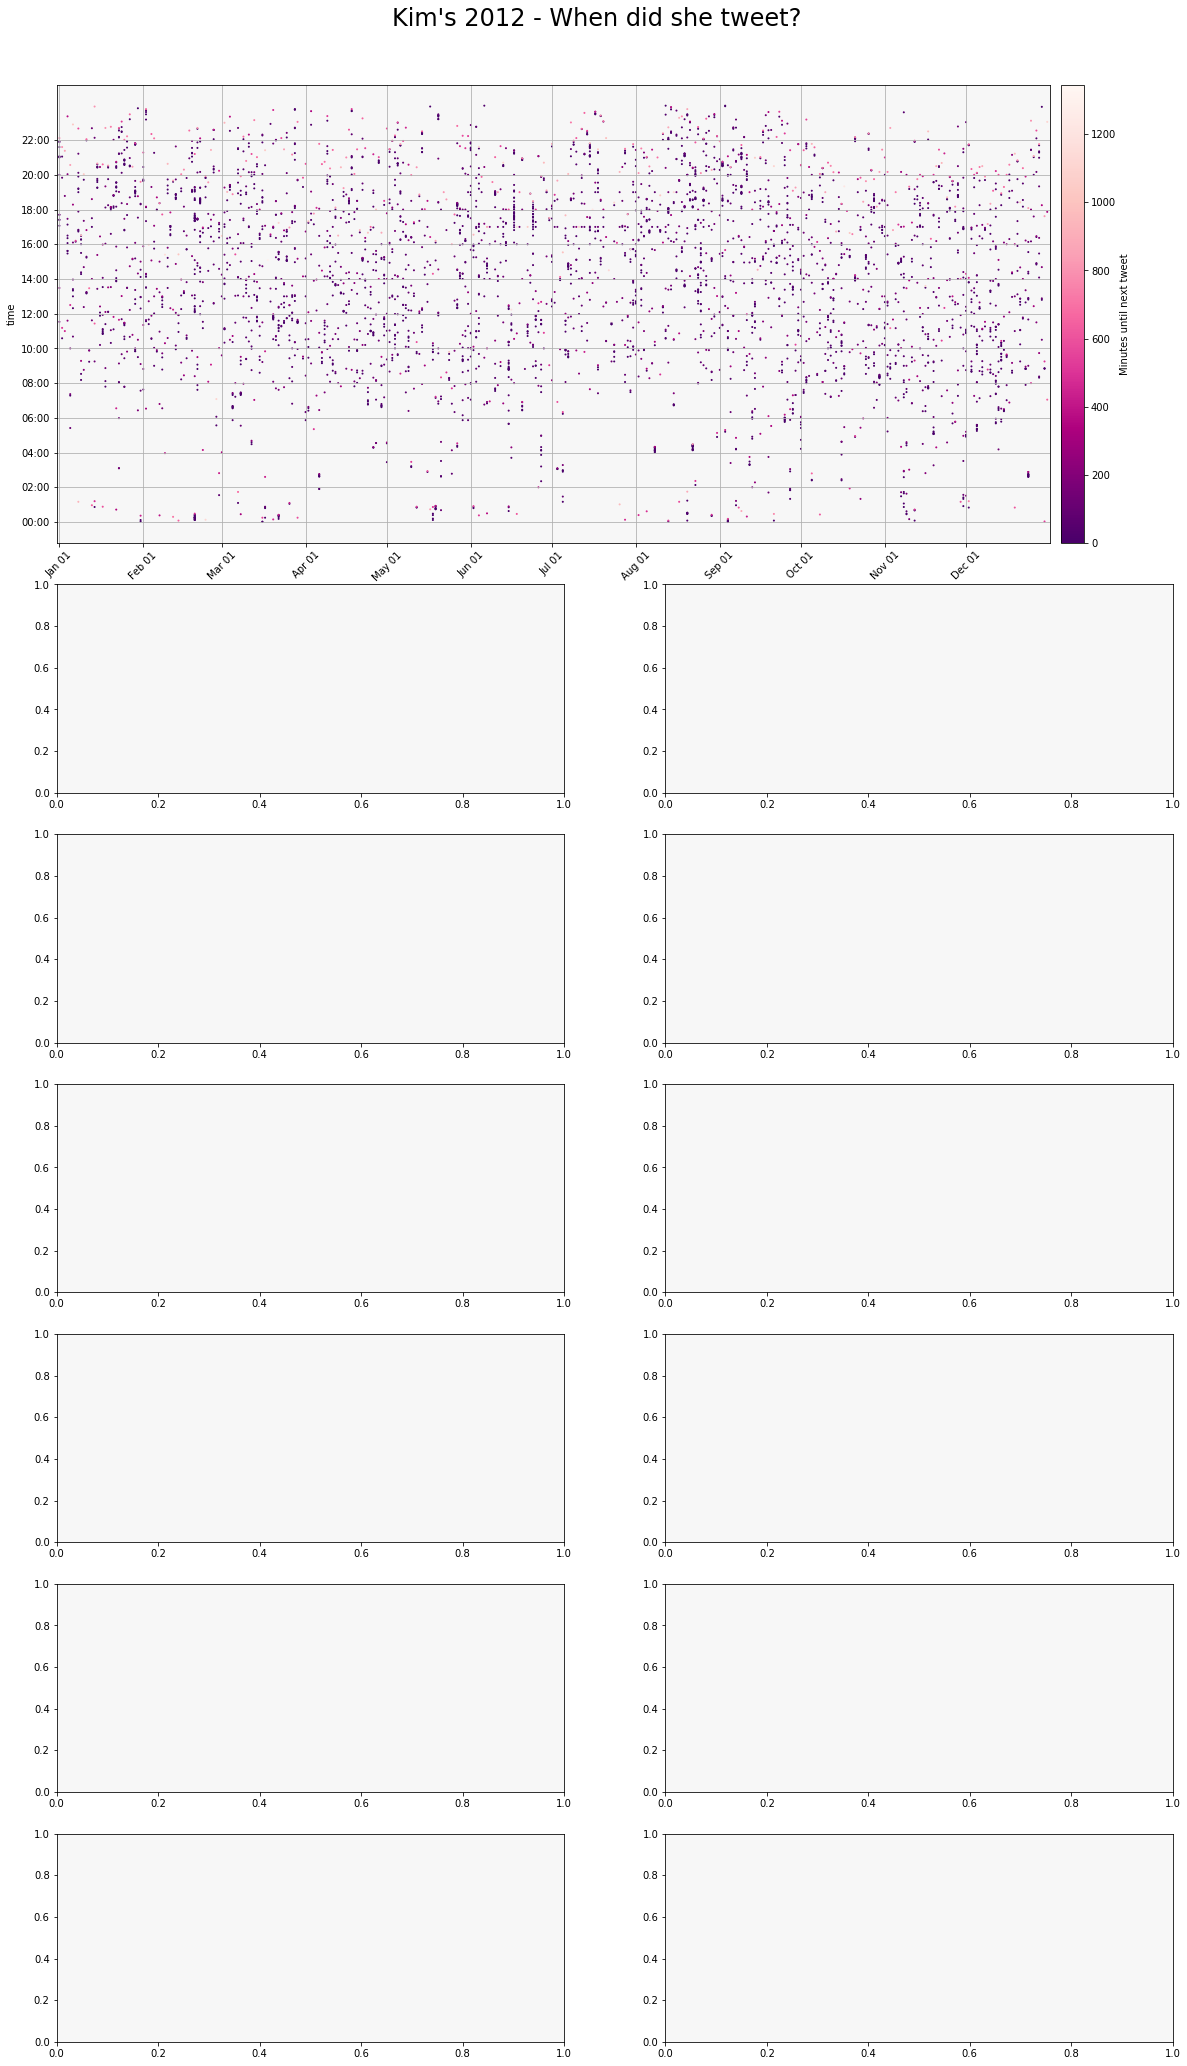

In [21]:
'''
Let's take a closer look at when Kim likes to tweet in 2012
'''
title = "Kim's 2012 - When did she tweet?"
bg_color = "#f7f7f7"
linecolor = "#078298"
fig = plt.figure(figsize=(20,36))
fig.suptitle(title, size=24, y=0.91)

# adding our axes
ax0 = plt.subplot2grid((8, 2), (0, 0), colspan=2, rowspan=2) # yearwise distribution big chart on top
ax1 = plt.subplot2grid((8, 2), (2, 0)) # jan           
ax2 = plt.subplot2grid((8, 2), (2, 1)) # feb         
ax3 = plt.subplot2grid((8, 2), (3, 0)) # mar          
ax4 = plt.subplot2grid((8, 2), (3, 1))
ax5 = plt.subplot2grid((8, 2), (4, 0))
ax6 = plt.subplot2grid((8, 2), (4, 1))           
ax7 = plt.subplot2grid((8, 2), (5, 0))  
ax8 = plt.subplot2grid((8, 2), (5, 1))   
ax9 = plt.subplot2grid((8, 2), (6, 0))            
ax10 = plt.subplot2grid((8, 2), (6, 1)) 
ax11 = plt.subplot2grid((8, 2), (7, 0))            
ax12 = plt.subplot2grid((8, 2), (7, 1)) 

for ax in fig.axes:
    ax.set_facecolor(bg_color)
    

# data for scatter
x_days = k2012['date'].sort_values().dt.date
alltimes = k2012['date'].sort_values().dt.strftime('%H:%M')
y_times = [datetime.datetime.strptime(t, '%H:%M').time() for t in alltimes]
# data for colorbar gradient - figuring out timedelta between tweet and next tweet
timeit = k2012['date'].sort_values().tolist()
minutes = []
for index, time in enumerate(timeit):
    next_index = (index + 1) % len(k2012)
    # when last date in 2012 is reached, first date of 2013 is used to create the delta
    if next_index == 0:
        delta = k2013["date"].sort_values().tolist()[0] - time
    # looking at next time and creating a delta (= how long until the next tweet)
    else:  
        delta = timeit[next_index] - time     
    m = delta.seconds / 60
    minutes.append(int(m))

# settings for colorbar
max_value = max(minutes)
min_value = min(minutes)
ax4_cmap = plt.get_cmap('RdPu_r')
norm = matplotlib.colors.Normalize(vmin=min_value,vmax=max_value)
sm = plt.cm.ScalarMappable(cmap=ax4_cmap, norm=norm)
sm.set_array([])
# adding the colorbar: 
cbar = fig.colorbar(sm, ax=ax0, label="Minutes until next tweet", fraction=0.1, pad=0.01)

# chart
scatter = ax0.scatter(x_days, y_times, s=1, c=minutes, cmap="RdPu_r")
ax0.set_facecolor(bg_color)
ax0.set_xlim([datetime.date(2011, 12, 31), datetime.date(2013, 1, 1)])
firsts = [datetime.date(2012, i, 1) for i in range(1,13)]
ax0.set_xticks(firsts)
y_tick_times = [f"{a:02d}:00:00" for a in range(24) if a%2==0] # list of times for y axis
ax0.set_yticks(y_tick_times)
ax0.set_xticklabels(firsts, rotation=45)
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax0.grid(axis='both', zorder=1, which='both')

In [22]:
# let's turn to our clean data to look at what she was talking about in 2012
years = np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
tweet_years = [clean2009, clean2010, clean2011, clean2012, clean2013, 
           clean2014, clean2015, clean2016, clean2017, clean2018, clean2019]

# let us join all those tweets together into giant strings almost as long as Kylie's bank statement
cloud_str_dict = {}
for index in range(len(tweet_years)):
    key = f"cloud{years[index]}"
    x = tweet_years[index]["lemmatized"].tolist() 
    cloud_str_dict[key] = " ".join(word for li in x for word in li)  

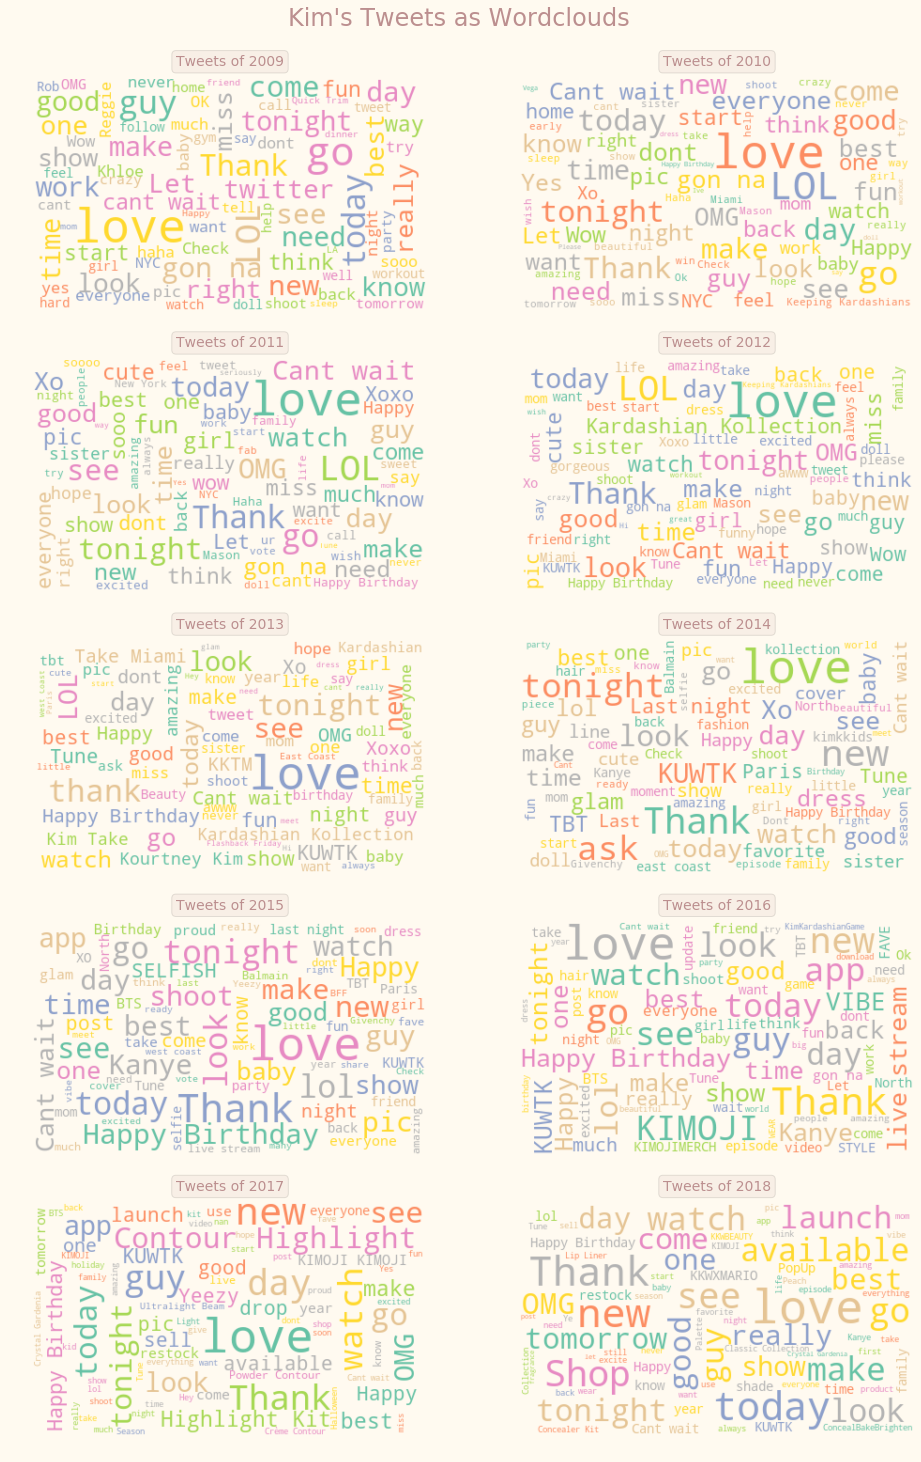

In [23]:
def cloudify(string):
    x = WordCloud(height=250, width=420, max_font_size=50, max_words=80, 
                  colormap="Set2", background_color="floralwhite").generate(string)
    return x

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,25))
fig.set_facecolor("floralwhite")
fig.suptitle("Kim's Tweets as Wordclouds", size=24, y=0.92, color="rosybrown")

index = 0
for x in range(5):
    for y in range(2):
        cloudy = cloudify(cloud_str_dict[f"cloud{years[index]}"])
        ax = axes[x,y]
        ax.imshow(cloudy, interpolation='bilinear')
        ax.set_title(f'Tweets of {years[index]}', fontsize=14, color="rosybrown", y=1.03,
                     bbox=dict(boxstyle="round", pad=0.3, fc="rosybrown", alpha=0.1, lw=1))
        ax.axis('off')
        index+=1

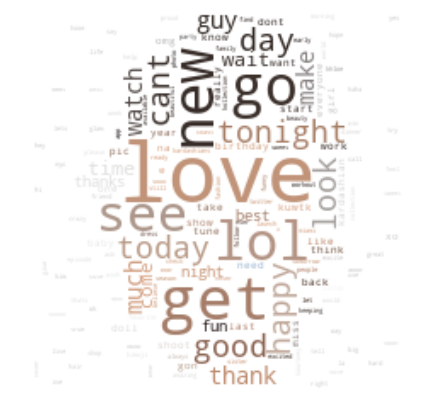

<BarContainer object of 10 artists>

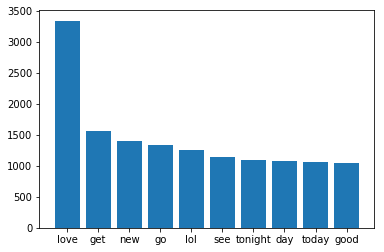

In [24]:
# let's look at what a cryface kimoji shaped wordcloud would look like
kim_mask = np.array(Image.open("kimoji.png"))

# putting all tweets into one single string
onestring = " ".join(cloud_str_dict.values())
all_tweet_word_list = re.split('\s+', onestring)
all_tweet_word_list = [w.lower() for w in all_tweet_word_list]
co = Counter(all_tweet_word_list)


# Generate a word cloud image
mask = np.array(Image.open("kimoji.png"))
wordcloud_kimoji = WordCloud(background_color="white", mode="RGBA", 
                             max_words=2000, mask=mask).generate_from_frequencies(co)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_kimoji.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

#generate_from_frequencies(text)
words = [item[0] for item in co.most_common(10)]
wordfreq = [item[1] for item in co.most_common(10)]
plt.bar(words, wordfreq)

In [ ]:
'''Kim is big into love... but what exactly does she love?'''

clean[clean['cleaned'].str.contains('love')==True].head()

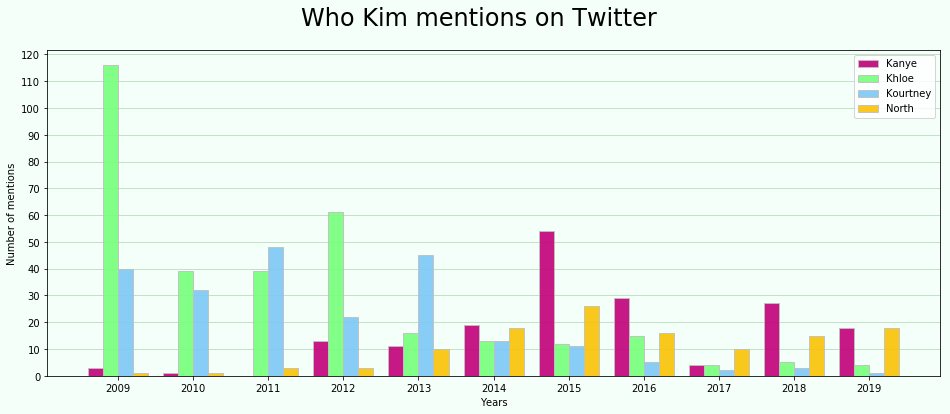

In [31]:


counterdict = {}
for key in cloud_str_dict.keys():
    counterdict[key] = Counter(cloud_str_dict[key].upper().split())

def wordcounter(wordstr):
    countlist = []
    for key in counterdict:
        wordnum = counterdict[key][wordstr.upper()]
        countlist.append(wordnum)
    return countlist


bg_c = "mintcream"
index = np.arange(len(years))
bar_width = 0.2
opacity = 0.9
barcolors = ['xkcd:magenta', 'xkcd:lightgreen', 'xkcd:lightblue', 'xkcd:goldenrod']
ec = "silver"

fig1 = plt.figure(figsize=(16, 6))
fig1.suptitle('Who Kim mentions on Twitter', size=24)
fig1.set_facecolor(bg_c)

ax1 = fig1.add_subplot(111)
ax1.set_facecolor(bg_c)

Kanye = ax1.bar(index, wordcounter("kanye"), width=bar_width, alpha=opacity, zorder=2,
                color=barcolors[0], ec=ec, label='Kanye')

Khloe = ax1.bar(index + bar_width, wordcounter("khloe"), width=bar_width, alpha=opacity, zorder=2,
               color=barcolors[1], ec=ec, label='Khloe')

Kourtney = ax1.bar(index + 2 * bar_width, wordcounter("kourtney"), width=bar_width, alpha=opacity, zorder=2,
                  color=barcolors[2], ec=ec, label='Kourtney')

North = ax1.bar(index + 3 * bar_width, wordcounter("north"), width=bar_width, alpha=opacity, zorder=2,
               color=barcolors[3], ec=ec, label='North')

plt.xticks(index + bar_width*1.5, years)
plt.grid(axis="y", c="forestgreen", zorder=2, alpha=.3)

ax1.set_xlabel('Years')
ax1.set_ylabel('Number of mentions')
ax1.set_yticks(np.arange(0,121,10))
ax1.legend()

plt.show()

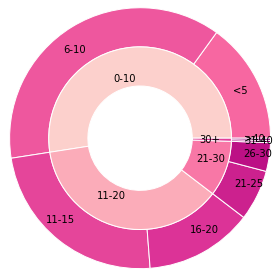

In [98]:
# this is just a test

quantities = np.array([
    [len([a for a in day_nums if a <= 5]), len([a for a in day_nums if 6 <= a <= 10])],
    [len([b for b in day_nums if 11 <= b <= 15]), len([b for b in day_nums if 16 <= b <= 20])],
    [len([c for c in day_nums if 21 <= c <= 25]), len([b for b in day_nums if 26 <= b <= 30])],
    [len([b for b in day_nums if 31 <= b <= 40]), len([d for d in day_nums if d > 40])]
])

explode1 = [0,0,0,0.1]

innerlabels = ["0-10", "11-20", "21-30", "30+"]
outerlabels = ["<5", "6-10","11-15","16-20","21-25","26-30","31-40",">40" ]


fig, ax = plt.subplots()
size = 0.45

cmap = plt.get_cmap("RdPu")
outer_colors = cmap(np.linspace(0.5, 0.8, 2*len(quantities)))
inner_colors = cmap(np.linspace(0.2, 0.6, len(quantities)))

outer = ax.pie(quantities.flatten(), labels=outerlabels, labeldistance=.8, radius=1.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

inner = ax.pie(quantities.sum(axis=1), labels=innerlabels, labeldistance=0.65, radius=1.5-size, 
               colors=inner_colors, wedgeprops=dict(width=size, edgecolor='w'))

#ax.set(aspect="equal", title='Pie plot with `ax.pie`')
'''
ax4 pie of daily tweet amount distribution 

# data
quantities = [len([a for a in day_nums if a <= 10]),
             len([b for b in day_nums if 11 <= b <= 20]),
             len([c for c in day_nums if 21 <= c <= 30]),
             len([d for d in day_nums if d > 30])]
explode1 = [0,0,0,0.1]
colors1 = plt.cm.RdPu(np.linspace(0.2, 0.9, len(quantities)))
labels = ["0-10 tweets", "11-20 tweets", "21-30 tweets", "30+ tweets"]


# graph
wedges, texts, autotexts = ax4.pie(quantities, labels=labels, explode=explode1, autopct=make_autopct(quantities),
                                    pctdistance=0.8, shadow=True, startangle=90, counterclock=False, 
                                    wedgeprops=dict(width=0.4), colors=colors1)
    
ax4.legend(title="Daily tweet amounts", loc="lower right", fancybox=True, shadow=True)
for text in texts:
    text.set_alpha(0)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontweight('demibold')
   
'''

